Mean Load: 50 ; Variance Load: 10


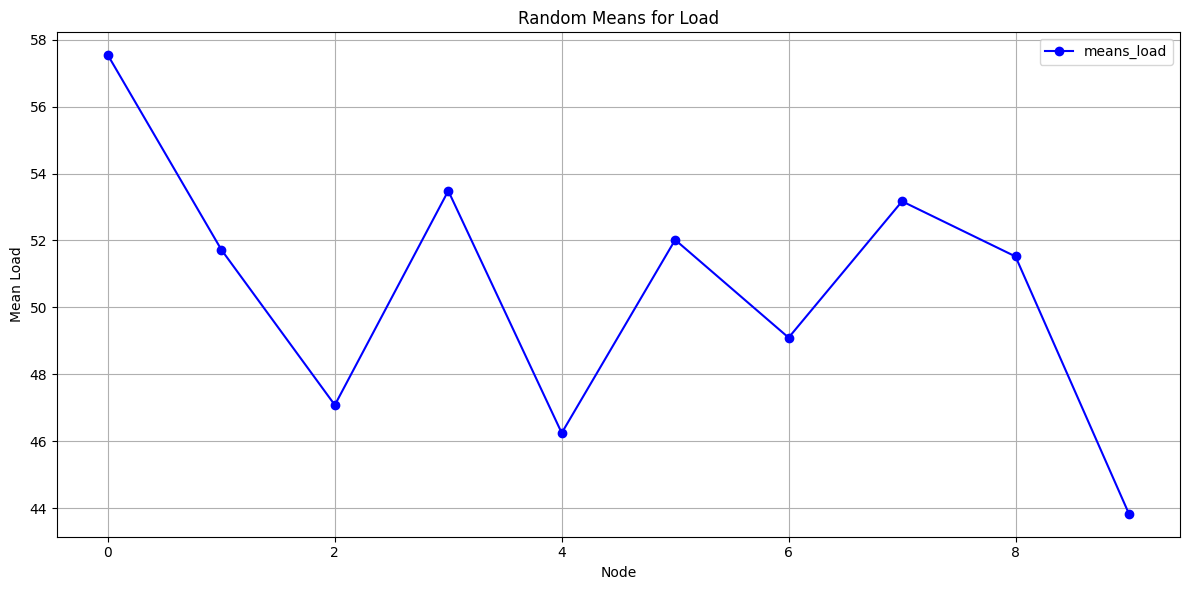

[57.53519536 51.72170516 47.0811007  53.48322254 46.24587364 52.01872646
 49.09518692 53.17035092 51.52089017 43.83044283]


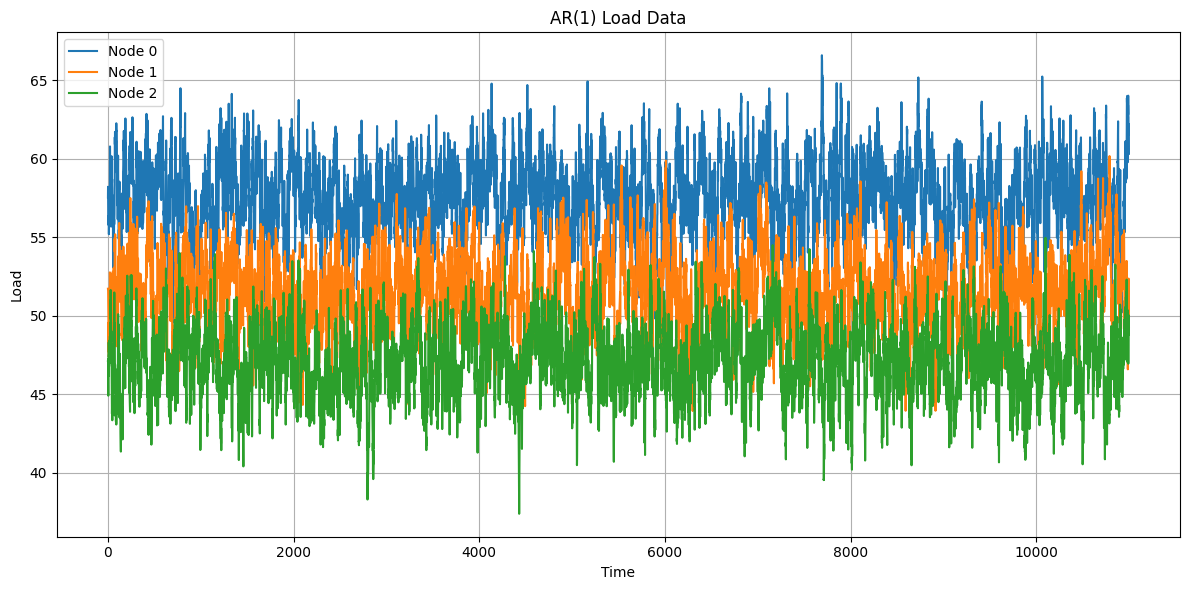

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


# Function to generate random means
def generate_means(N, mean_load, var_load):
    print('Mean Load:', mean_load, '; Variance Load:', var_load)
    means_load = np.random.normal(loc=mean_load, scale=np.sqrt(var_load), size=N)

    # Plotting means_load
    plt.figure(figsize=(12, 6))
    plt.plot(means_load, marker='o', linestyle='-', color='b', label='means_load')
    plt.title('Random Means for Load')
    plt.xlabel('Node')
    plt.ylabel('Mean Load')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

    return means_load


# Function to generate IID data
def generate_iid_data(N, T, means_load):
    loads = np.array([np.random.normal(loc=means_load[i], scale=1, size=T) for i in range(N)])

    return loads, np.mean(loads, axis=1)


# Function to generate AR(1) data
def generate_ar1_data(N, T, means_load, theta):
    loads = np.zeros((N, T))

    def generate_ar1(theta, T, mean_node):
        ar1 = np.zeros(T)
        ar1[0] = mean_node
        for t in range(1, T):
            ar1[t] = theta * ar1[t - 1] + (1 - theta) * mean_node + np.random.normal(0, 1)
        return ar1

    for i in range(N):
        loads[i] = generate_ar1(theta, T, means_load[i])

    return loads, np.mean(loads, axis=1)


# 绘制指定范围内的AR(1)数据
def plot_ar1_data(load_data, start, end):
    N, T = load_data.shape
    time_steps = np.arange(start, end)

    plt.figure(figsize=(12, 6))
    for i in range(N):
        plt.plot(time_steps, load_data[i, start:end], label=f'Node {i}')
    plt.title('AR(1) Load Data')
    plt.xlabel('Time')
    plt.ylabel('Load')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()


N = 10
T_train = 10000
T_test = 1000
T = T_train + T_test
mean_load = 50
var_load = 10

means_load = generate_means(N, mean_load, var_load)
print(means_load)

# Generate IID data
load_iid, load_iid_means = generate_iid_data(N, T, means_load)

# Generate AR(1) data
theta = 0.9
load_ar1, load_ar1_means = generate_ar1_data(N, T, means_load, theta)
# Plotting AR(1) data
plot_ar1_data(load_ar1[:3], 0, T)

Data exported to load_iid_data.csv
Data exported to load_ar1_data.csv


In [0]:
class LSTMExpert:
    def __init__(self, data, T_train, T_test, batch_size=32, seq_length=20,
                 input_size=10, hidden_size=50, output_size=10, num_layers=2,
                 learning_rate=0.001, num_epochs=100, num_workers=16, mix_precision=True, device='cpu'):
        self.data = data  # 数据
        self.T_train = T_train  # 训练集长度
        self.T_test = T_test  # 测试集长度
        self.batch_size = batch_size  # 批次大小
        self.seq_length = seq_length  # 序列长度
        self.input_size = input_size  # 输入维度
        self.hidden_size = hidden_size  # 隐藏层维度
        self.output_size = output_size  # 输出维度
        self.num_layers = num_layers  # LSTM层数
        self.learning_rate = learning_rate  # 学习率
        self.num_epochs = num_epochs  # 训练轮数
        self.num_workers = num_workers  # 数据加载器的工作线程数
        self.device = device  # 设备
        self.mix_precision = mix_precision  # 混合精度训练

        # 数据处理，将数据转换为张量，但不放到GPU上，因为数据加载器会自动将数据放到GPU上
        self.train_data = torch.tensor(self.data[:, :self.T_train], dtype=torch.float32)
        self.test_data = torch.tensor(self.data[:, self.T_train:], dtype=torch.float32)

        # 创建模型
        self.model = self.LSTMModel(self.input_size, self.hidden_size, self.output_size, self.num_layers).to(
            self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # 生成训练集
        sequences, targets = self._create_sequences(self.train_data, self.seq_length, self.T_train)
        # sequences = torch.tensor(sequences, dtype=torch.float32).to(self.device)
        # targets = torch.tensor(targets, dtype=torch.float32).to(self.device)

        print(f'sequences shape: {sequences.shape}')
        print(f'targets shape: {targets.shape}')

        self.train_dataset = TensorDataset(sequences, targets)
        self.dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                                     num_workers=self.num_workers, pin_memory=True)

        print(f'size of input x: {sequences.shape}')
        print(f'size of target y: {targets.shape}')
        print(f'size of train dataset: {len(self.train_dataset)}')
        print(f'Number of batches: {len(self.dataloader)}')
        self.info_dataloader()

        self.predictions = None
        self.true_values = None

        self.total_avg_loss = 0

    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, output_size, num_layers=1):
            super().__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.lstm(x, (h_0, c_0))
            out = self.fc(out[:, -1, :])
            return out

    @staticmethod
    # 切分时间序列为多个样本
    def _create_sequences(data, seq_length, T_train):
        sequences = []
        targets = []
        for i in range(T_train - seq_length):
            # 循环次数不是T_train - seq_length + 1，因为训练集里并没有第10001个真实数据作为target。
            # 最后一次生成的序列会在逐步更新的过程中使用，而不是在初始训练集中。
            seq = data[:, i: i + seq_length].T
            target = data[:, i + seq_length]
            sequences.append(seq)
            targets.append(target)
        # return np.array(sequences), np.array(targets)
        # 将列表中的张量堆叠成一个更大的张量，并确保它们保持在 GPU 上
        return torch.stack(sequences), torch.stack(targets)

    def info_dataloader(self):
        total_batches = len(self.dataloader)
        for i, batch in enumerate(self.dataloader):
            if i % 30 == 0 or i == total_batches - 1:  # 每30次打印一次，确保最后一次打印
                inputs, targets = batch
                print(f'{i:>3}: Inputs Shape: {inputs.shape}, Targets Shape: {targets.shape}')

    def train(self):
        scaler = torch.amp.GradScaler(device=self.device) if self.mix_precision else None

        self.model.train()
        for epoch in tqdm(range(self.num_epochs), desc="Training"):
            for inputs, targets in self.dataloader:
                # 确保数据在 GPU 上，且异步加载
                inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)

                self.optimizer.zero_grad()  # 梯度清零

                if self.mix_precision:  # 混合精度训练
                    with torch.amp.autocast(device_type=self.device.type):
                        outputs = self.model(inputs)
                        loss = self.criterion(outputs, targets)

                    scaler.scale(loss).backward()
                    scaler.step(self.optimizer)
                    scaler.update()

                else:
                    outputs = self.model(inputs)  # 前向传播
                    loss = self.criterion(outputs, targets)  # 计算损失
                    loss.backward()  # 反向传播
                    self.optimizer.step()  # 更新参数

            if (epoch + 1) % 10 == 0:  # 每10轮输出一次损失, 以及释放GPU缓存
                print(f'Epoch [{epoch + 1}/{self.num_epochs}], Loss: {loss.item():.4f}')

                if torch.cuda.is_available():  # 释放GPU缓存
                    torch.cuda.empty_cache()

                print(f'device: {torch.cuda.get_device_name()}')

    def predict_and_fine_tune(self):
        total_loss = 0
        # predictions = []
        # true_values = []
        predictions = torch.zeros((self.T_test, self.output_size), device=self.device)
        true_values = torch.zeros((self.T_test, self.output_size), device=self.device)

        x_test = self.train_data[:, -self.seq_length:].T.unsqueeze(0).to(self.device)
        self.test_data = self.test_data.to(self.device)

        for i in tqdm(range(self.T_test), desc="Predicting and Fine-tuning"):
            self.model.train()  # 模型保持在训练模式，以便进行微调
            pred = self.model(x_test)  # 预测
            real_value = self.test_data[:, i].to(self.device)  # 真实值

            # predictions.append(pred.squeeze(0).detach().cpu().numpy())
            # # 形状[1, 10]转换为 [10], 从计算图中分离(以分离开梯度，不然没法使用.numpy())，从GPU转移到CPU, 最后转为 NumPy 数组
            # true_values.append(real_value.detach().cpu().numpy())

            predictions[i] = pred.squeeze(0)
            true_values[i] = real_value

            loss = self.criterion(pred.squeeze(0), real_value)  # 计算损失
            total_loss += loss.item()  # 累加损失
            if (i + 1) % 100 == 0:  # 每100步输出一次损失
                print(f'Step {i + 1}/{self.T_test}, Loss: {loss.item():.4f}')

            # 使用真实值进行微调
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # 更新输入序列
            x_test = torch.cat((x_test[:, 1:, :], real_value.unsqueeze(0).unsqueeze(0)), dim=1)

        # 计算平均损失
        avg_loss = total_loss / self.T_test
        print(f'Average Fine-tuning Loss over {self.T_test} steps: {avg_loss:.4f}')

        self.total_avg_loss = avg_loss

        # 将预测值和真实值转换为 NumPy 数组
        # self.predictions = np.array(predictions)
        # self.true_values = np.array(true_values)
        self.predictions = predictions.detach().cpu().numpy()
        self.true_values = true_values.detach().cpu().numpy()

    def get_prediction_at_time(self, t):
        if self.predictions is None or self.true_values is None:
            raise ValueError("You must run predict_and_fine_tune() before accessing predictions.")
        return self.predictions[t], self.true_values[t]

    def get_total_avg_loss(self):
        return self.total_avg_loss

    def plot_results(self, predictions, true_values):
        plt.figure(figsize=(12, 6))
        plt.plot(predictions[:, 0], label='Predicted')
        plt.plot(true_values[:, 0], label='True')
        plt.xlabel('Time Steps')
        plt.ylabel('Load Value')
        plt.title('Predicted vs True Load Values for Node 1')
        plt.legend()
        plt.show()


data = load_ar1

# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 定义训练集和测试集的长度
T_train = 10000
T_test = 1000
batch_size = 512
seq_length = 20
input_size = 10
hidden_size = 50
output_size = 10
num_layers = 2
learning_rate = 0.001
num_epochs = 100
num_workers = 24
mix_precision = True

# 初始化专家
expert = LSTMExpert(data, T_train, T_test, batch_size, seq_length, input_size, hidden_size, output_size, num_layers,
                    learning_rate, num_epochs, num_workers, mix_precision, device)
%%time
# 训练模型
expert.train()
%%time
# 预测并微调
expert.predict_and_fine_tune()
# 获取第 t 次的预测结果
t = 50
predicted, true_value = expert.get_prediction_at_time(t)
print(f"Predicted values for t={t}: {predicted}")
print(f"True values for t={t}: {true_value}")
# 绘制预测与真实值对比图
expert.plot_results(expert.predictions, expert.true_values)

data = load_ar1

# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 定义训练集和测试集的长度
T_train = 10000
T_test = 1000
batch_size = 64
seq_length = 20
input_size = 10
hidden_size = 50
output_size = 10
num_layers = 2
learning_rate = 0.001
num_epochs = 100
num_workers = 24
mix_precision = True

# 初始化专家
expert1 = LSTMExpert(data, T_train, T_test, batch_size, seq_length, input_size, hidden_size, output_size, num_layers,
                     learning_rate, num_epochs, num_workers, mix_precision, device)
%%time
# 训练模型
expert1.train()
%%time
# 预测并微调
expert1.predict_and_fine_tune()
# 获取第 t 次的预测结果
t = 50
predicted, true_value = expert1.get_prediction_at_time(t)
print(f"Predicted values for t={t}: {predicted}")
print(f"True values for t={t}: {true_value}")
# 绘制预测与真实值对比图
expert1.plot_results(expert1.predictions, expert1.true_values)

